# Trading with Machine Learning Models

This tutorial will show how to train and backtest a 
[machine learning](https://en.wikipedia.org/wiki/Machine_learning)
price forecast model with _backtesting.py_ framework. It is assumed you're already familiar with
[basic framework usage](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html)
and machine learning in general.

For this tutorial, we'll use almost a year's worth sample of hourly EUR/USD forex data:

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')
from backtesting.test import SMA

In [5]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    raw_data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('Remote')
    raw_data = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [6]:
data = raw_data.resample('H').agg({
    'Open': 'first',
    'Close': 'last',
    'High': 'max',
    'Low': 'min',
    'Volume': 'sum'
})
data.dropna(subset=['Close'], inplace=True)

In
[supervised machine learning](https://en.wikipedia.org/wiki/Supervised_learning), 
we try to learn a function that maps input feature vectors (independent variables) into known output values (dependent variable):

$$ f\colon X \to \mathbf{y} $$

That way, provided our model function is sufficient, we can predict future output values from the newly acquired input feature vectors to some degree of certainty.
In our example, we'll try to map several price-derived features and common technical indicators to the price point two days in the future.
We construct [model design matrix](https://en.wikipedia.org/wiki/Design_matrix) $X$ below:

In [7]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

Since all our indicators work only with past values, we can safely precompute the design matrix in advance. Alternatively, we would reconstruct the matrix every time before training the model.

Notice the made-up _sentiment_ feature. In real life, one would obtain similar features by parsing news sources, Twitter sentiment, Stocktwits or similar.
This is just to show input data can contain all sorts of additional explanatory columns.

As mentioned, our dependent variable will be the price (return) two days in the future, simplified into values $1$ when the return is positive (and significant), $-1$ when negative, or $0$ when the return after two days is roughly around zero. Let's write some functions that return our model matrix $X$ and dependent, class variable $\mathbf{y}$ as plain NumPy arrays:

In [8]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Let's see how our data performs modeled using a simple
[k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
(kNN) algorithm from the state of the art
[scikit-learn](https://scikit-learn.org)
Python machine learning package.
To avoid (or at least demonstrate)
[overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html),
always split your data into _train_ and _test_ sets; in particular, don't validate your model performance on the same data it was built on.

Classification accuracy:  0.4422772799156563


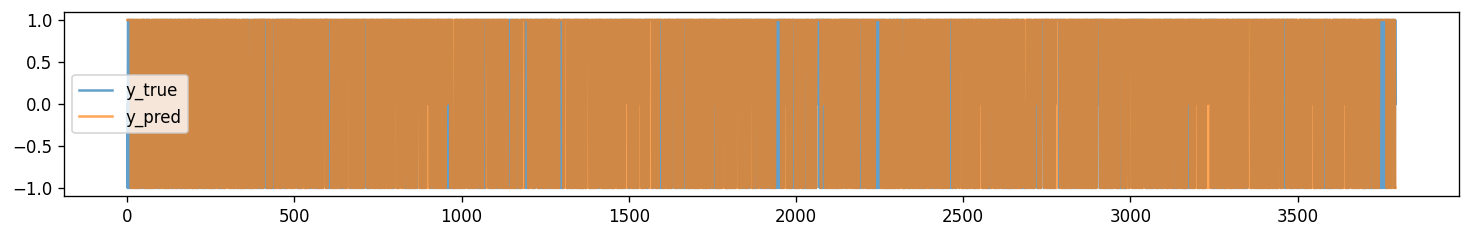

In [9]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

We see the forecasts are all over the place (classification accuracy 42%), but is the model of any use under real backtesting?

Let's backtest a simple strategy that buys the asset for 20% of available equity with 20:1 leverage whenever the forecast is positive (the price in two days is predicted to go up),
and sells under the same terms when the forecast is negative, all the while setting reasonable stop-loss and take-profit levels. Notice also the steady use of
[`data.df`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.data)
accessor:

In [10]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

CPU times: user 10.5 s, sys: 15.9 ms, total: 10.5 s
Wall time: 10.5 s


Start                     2018-09-10 14:00:00
End                       2024-10-25 09:00:00
Duration                   2236 days 19:00:00
Exposure Time [%]                   38.297315
Equity Final [$]                     216.2308
Equity Peak [$]                   11134.51222
Return [%]                         -97.837692
Buy & Hold Return [%]               42.683187
Return (Ann.) [%]                  -46.841617
Volatility (Ann.) [%]               13.991532
Sharpe Ratio                        -3.347855
Sortino Ratio                       -2.224721
Calmar Ratio                        -0.477693
Max. Drawdown [%]                  -98.058013
Avg. Drawdown [%]                  -11.780979
Max. Drawdown Duration     2092 days 22:00:00
Avg. Drawdown Duration      212 days 01:00:00
# Trades                                 1816
Win Rate [%]                        39.647577
Best Trade [%]                        4.19347
Worst Trade [%]                     -2.791569
Avg. Trade [%]                    

In [11]:
bt.plot()

GridPlot(id='p1414', ...)

Despite our lousy win rate, the strategy seems profitable. Let's see how it performs under
[walk-forward optimization](https://en.wikipedia.org/wiki/Walk_forward_optimization),
akin to k-fold or leave-one-out
[cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29):

In [7]:
%%time

class MLWalkForwardStrategy(MLTrainOnceStrategy):
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return

        # Re-train the model only every 20 iterations.
        # Since 20 << N_TRAIN, we don't lose much in terms of
        # "recent training examples", but the speed-up is significant!
        if len(self.data) % 20:
            return super().next()

        # Retrain on last N_TRAIN values
        df = self.data.df[-N_TRAIN:]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        super().next()


bt = Backtest(data, MLWalkForwardStrategy, commission=.0002, margin=.05)
bt.run()

CPU times: user 10.4 s, sys: 8.24 ms, total: 10.4 s
Wall time: 10.4 s


Start                     2017-04-25 12:00:00
End                       2018-02-07 15:00:00
Duration                    288 days 03:00:00
Exposure Time [%]                       71.72
Equity Final [$]                      5885.37
Equity Peak [$]                      10052.84
Return [%]                             -41.15
Buy & Hold Return [%]                   12.87
Max. Drawdown [%]                      -41.47
Avg. Drawdown [%]                      -14.36
Max. Drawdown Duration      261 days 18:00:00
Avg. Drawdown Duration       88 days 05:00:00
# Trades                                  324
Win Rate [%]                            41.67
Best Trade [%]                           0.38
Worst Trade [%]                         -0.51
Avg. Trade [%]                          -0.05
Max. Trade Duration           3 days 07:00:00
Avg. Trade Duration           0 days 18:00:00
Profit Factor                            0.67
Expectancy [%]                           0.25
SQN                               

In [8]:
bt.plot()

Apparently, when repeatedly retrained on past `N_TRAIN` data points in a rolling manner, our basic model generalizes poorly and performs not quite as well.

This was a simple and contrived, tongue-in-cheek example that shows one way to use machine learning forecast models with _backtesting.py_ framework.
In reality, you will need a far better feature space, better models (cf.
[deep learning](https://en.wikipedia.org/wiki/Deep_learning#Deep_neural_networks)),
and better money management strategies to achieve
[consistent profits](https://en.wikipedia.org/wiki/Day_trading#Profitability)
in automated short-term forex trading. More proper data science is an exercise for the keen reader.

Some instant optimization tips that come to mind are:
* **Data is king.** Make sure your design matrix features as best as possible model and correlate with your chosen target variable(s) and not just represent random noise.
* Instead of modelling a single target variable $y$, model a multitude of target/class variables, possibly better designed than our "48-hour returns" above.
* **Model everything:** forecast price, volume, time before it "takes off", SL/TP levels,
  [optimal position size](https://en.wikipedia.org/wiki/Kelly_criterion#Application_to_the_stock_market)
  ...
* Reduce
  [false positives](https://en.wikipedia.org/wiki/False_positive_rate)
  by increasing the conviction needed and imposing extra domain expertise and discretionary limitations before entering trades.

Also make sure to familiarize yourself with the full
[Backtesting.py API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules)